## Loading of Steinmetz data

includes some visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

# FEATURES

In [ ]:
type(alldat)

numpy.ndarray

In [ ]:
len(alldat) # number of sessions

39

In [ ]:
alldat[0].keys() # columns in first session


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

Q1: How many unique mice are used in these 39 sessions? Name them

Q2: Which mouse took part in most sessions? And which the least? Make a bar plot to visualize the same

Q3: On average, what is the number of sessions each mouse has taken part in?

In [ ]:
mouse_names = [dat['mouse_name'] for dat in alldat]

In [ ]:
unique_mice = {dat['mouse_name'] for dat in alldat}

In [ ]:
from collections import defaultdict
mice = {}
for um in unique_mice:
  mice[um] = mouse_names.count(um)

In [ ]:
mice

{'Lederberg': 7,
 'Moniz': 3,
 'Radnitz': 5,
 'Hench': 4,
 'Muller': 3,
 'Cori': 3,
 'Richards': 5,
 'Theiler': 1,
 'Tatum': 4,
 'Forssmann': 4}

In [ ]:
np.median([val for val in mice.values()])

4.0

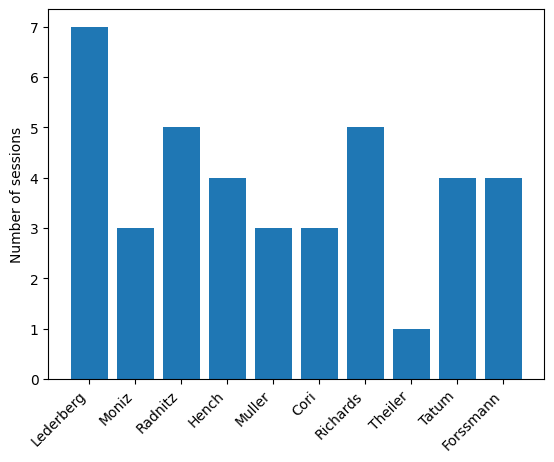

In [ ]:
import matplotlib.pyplot as plt

plt.bar(x=mice.keys(),height=mice.values())
plt.ylabel("Number of sessions")
plt.xticks(rotation=45, ha='right');

In [ ]:
names = []
net_feedback = []
num_values = []
mean_feedback_time = []
for dat in alldat:
  names.append(dat["mouse_name"])
  net_feedback.append(sum(dat['feedback_type']))
  num_values.append(len(dat['feedback_type']))
  mean_feedback_time.append(dat['feedback_time'].mean())

In [ ]:
sum([-1]*10 + [1]*10)

0

In [ ]:
mouse_feedback = pd.DataFrame({'names':names, 'net_feedback':net_feedback, 'num_values':num_values, 'mean_feedback_time':mean_feedback_time})

In [ ]:
mouse_feedback['proportion_pos_feedback'] = mouse_feedback['net_feedback'] / mouse_feedback['num_values']
mouse_feedback['proportion_pos_feedback'] = mouse_feedback['proportion_pos_feedback'].round(2)

In [ ]:
mouse_feedback

,names,net_feedback,num_values,mean_feedback_time,proportion_pos_feedback
0,Cori,68.0,214,1.614839,0.32
1,Cori,67.0,251,1.643267,0.27
2,Cori,74.0,228,1.584537,0.32
3,Forssmann,83.0,249,1.716380,0.33
4,Forssmann,82.0,254,1.558036,0.32
5,Forssmann,140.0,290,1.397078,0.48
6,Forssmann,86.0,252,1.328577,0.34
7,Hench,72.0,250,1.619337,0.29
8,Hench,138.0,372,1.551972,0.37
9,Hench,107.0,447,1.560114,0.24


In [ ]:
mouse_feedback_pos = (mouse_feedback[['names', 'proportion_pos_feedback']].groupby(by="names").mean()*100).round(0)

In [ ]:
mouse_feedback_pos = mouse_feedback_pos.reset_index()

<Axes: xlabel='names'>

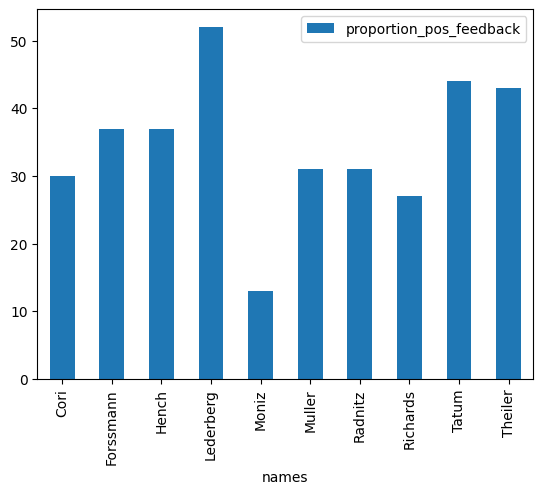

In [ ]:
mouse_feedback_pos.plot.bar(x='names', y='proportion_pos_feedback')

<Axes: xlabel='names'>

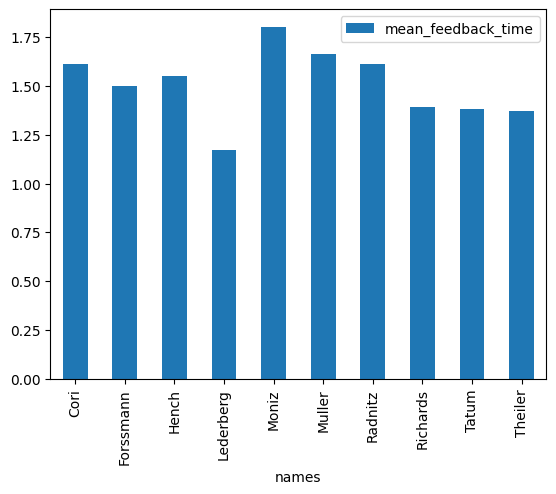

In [ ]:
mouse_feedback_time = (mouse_feedback[['names', 'mean_feedback_time']].groupby(by="names").mean()).round(2)
mouse_feedback_time = mouse_feedback_time.reset_index()
mouse_feedback_time.plot.bar(x='names', y='mean_feedback_time')

In [ ]:
mouse_fb = pd.DataFrame(data = {
    'names':mouse_feedback_pos.names,
    'proportion_pos_feedback':mouse_feedback_pos.proportion_pos_feedback,
    'mean_feedback_time':mouse_feedback_time.mean_feedback_time,
})
mouse_fb

,names,proportion_pos_feedback,mean_feedback_time
0,Cori,30.0,1.61
1,Forssmann,37.0,1.50
2,Hench,37.0,1.55
3,Lederberg,52.0,1.17
4,Moniz,13.0,1.80
5,Muller,31.0,1.66
6,Radnitz,31.0,1.61
7,Richards,27.0,1.39
8,Tatum,44.0,1.38
9,Theiler,43.0,1.37


<ipython-input-110-da647699a005>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = mouse_fb.corr()


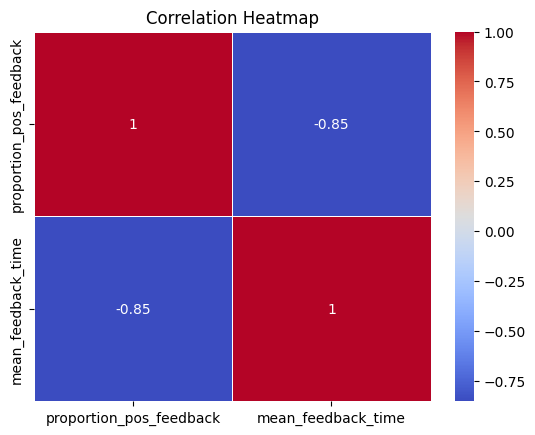

In [ ]:
import seaborn as sns
correlation_matrix = mouse_fb.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()